# Simple Aperture Photometry<img src='images/logo.png' width="200" height="200" align='right'>

We have now arrived at one of the most fundamental processes in all of astronomy: measuring brightness. There is a lot of subtlety to doing this the correct way. Here we touch on the basics of photometry and we leave the gory details for later. 

Full disclosure: some of this notebook was stolen from the [python workshop offered at the 227th AAS meeting in Florida](https://github.com/spacetelescope/AAS2016). It has otherwise been iterated on and adapted to our specific purposes.

As always, we begin by importing some very useful packages.

You should have everything already installed. The only one you might not have is `photutils`. If you don't have this one, you can install it on the Terminal command line with the command:
`pip install photutils`


In [107]:
# Numpy and matplotlib, you will get used to these packages.
import numpy as np
import matplotlib.pyplot as plt
import glob

# Here we change some global plotting parameters.
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# Here's a cool progress bar...
from tqdm.notebook import tqdm

# run the %matplotlib magic command to enable inline plotting in the current Notebook
#%matplotlib inline

In [108]:
# We will be using lots of astropy stuff...
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits

## Image Calibration
Let's first read in the master bias, dark, and flat frames from the data directory.

In [109]:
bias,bh = fits.getdata('data/SN/20170713/master_bias.fits',header=True)
dark,dh = fits.getdata('data/SN/20170713/master_dark.fits',header=True)
flat,fh = fits.getdata('data/SN/20170713/master_flat_V.fits',header=True)

Let's look at these calibration frames to make sure they look good.

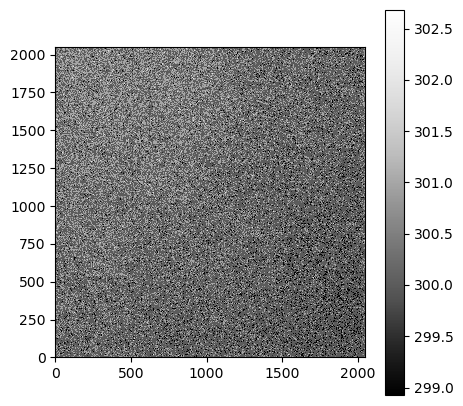

In [110]:
%matplotlib inline
#Matplotlib notebook has been known to cause problems with Jupyter notebooks, particularly with used in VS Code.
plt.figure(1,figsize=(5,5))
plt.imshow(bias,vmin=np.median(bias)-2*np.std(bias),vmax=np.median(bias)+5*np.std(bias))
plt.colorbar()

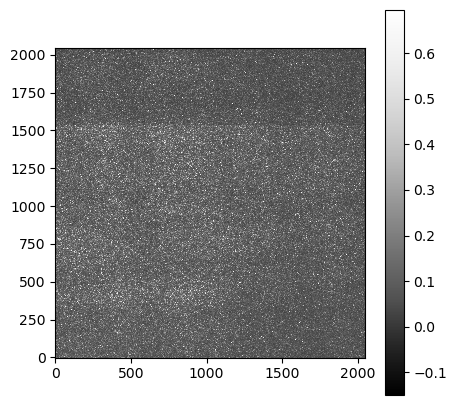

In [111]:
plt.figure(2,figsize=(5,5))
plt.imshow(dark,vmin=np.median(dark)-2*np.std(dark),vmax=np.median(dark)+5*np.std(dark))
plt.colorbar()

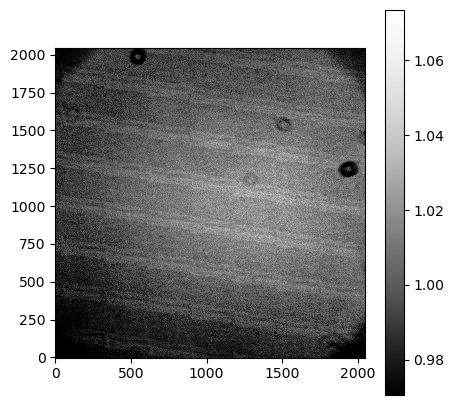

In [112]:
plt.figure(3,figsize=(5,5))
plt.imshow(flat,vmin=np.median(flat)-2*np.std(flat),vmax=np.median(flat)+5*np.std(flat))
plt.colorbar()

OK, these look good. Now let us take a look at our science frames.

In [113]:
sfiles = glob.glob('data/SN/20170713/SN*fits')
sct = len(sfiles)
sfiles

['data/SN/20170713/SN2017fgc-20170713at104546-Temp-30-Bin1-Exp120-V_solved.fits',
 'data/SN/20170713/SN2017fgc-20170713at103841-Temp-30-Bin1-Exp120-V_solved.fits',
 'data/SN/20170713/SN2017fgc-20170713at104104-Temp-30-Bin1-Exp120-V_solved.fits',
 'data/SN/20170713/SN2017fgc-20170713at103616-Temp-30-Bin1-Exp120-V_solved.fits',
 'data/SN/20170713/SN2017fgc-20170713at104323-Temp-30-Bin1-Exp120-V_solved.fits']

Looks like there are 5 target files. Let us first take a look at a calibrated image and see what it looks like

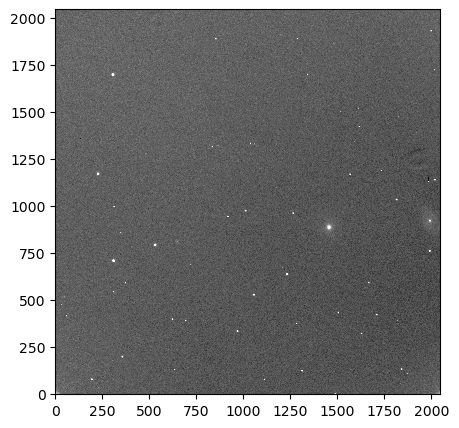

In [114]:
im, head = fits.getdata(sfiles[0],header=True)
cal = (im-bias-dark*head['EXPTIME'])/flat
plt.figure(4,figsize=(5,5))
plt.imshow(cal,vmin=np.median(cal)-2*np.std(cal),vmax=np.median(cal)+5*np.std(cal))

## Source Identification
Well, the field does not look perfectly flat, but it doesn't look bad either. Now there is supposed to be a supernova in this image somewhere, and it is  hard to tell what is going on with such a short exposure image.

Luckily, we have the J2000 coordinates AND some knowledge of how to use WCS.

In [115]:
# Given coordinates
rastr  = '01:20:14.44'
decstr = '+03:24:09.96'

# Make an astropy coordinate object out of the coordinates
coords = SkyCoord(rastr,decstr,unit=(u.hour,u.deg))

# Return RA and Dec in decimal degrees
ra  = coords.ra.deg
dec = coords.dec.deg

print(ra, dec)

20.060166666666664 3.4027666666666665


Now let us get the x and y pixel values for the object given the astrometry in the header of the image and plot it up on the image.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


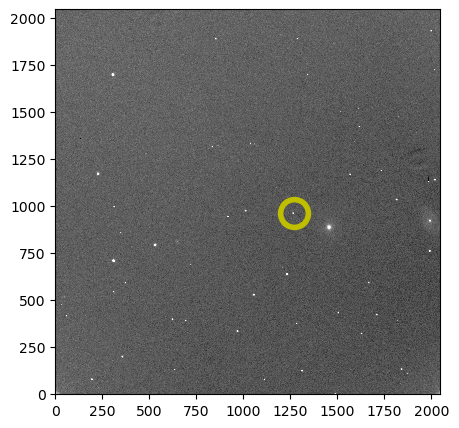

In [116]:
# This command parses and extracts the information about the celestial coordinates of each pixel
w = wcs.WCS(head)
# This converts an RA and Dec value to x and y pixel value
x,y = w.all_world2pix(ra, dec, 1)

# Plot up the figure
plt.figure(5,figsize=(5,5))
plt.imshow(cal,vmin=np.median(cal)-2*np.std(cal),vmax=np.median(cal)+5*np.std(cal))
plt.plot(x,y,'o',markerfacecolor='none',ms=20,markeredgecolor='y',markeredgewidth=4)
plt.show()

Ok... that is pretty convincing! Now, how do we measure how bright it is? This is where we introduce the concept of aperture photometry. 

## Simple Aperture Photometry

Aperture photometry is the process by which one tallies the number of counts (pixel values) within a region, called an aperture. That aperture is typically circular, but it can be adapted to be ellipsoidal, or square, or anything, really. For a cicular aperture, this process is  not as straightforward as one might assume, particularly because the pixels are rectangular. There are different methods for doing this that require different levels of computational expense. We will be interested in doing an exact calculation since the brightness is an important value and we don't want to compromise.
<img src="images/photutils_aperture_methods.svg">

In addition to counting up all the pixel values in an aperture, we will want to subtract the background since this may be due to the sky brightness, scattered light, or other phenomena not associated with the astronomical source of interest. Therefore, we define an annulus around the source that (ideally) has no astronomical sources within it. The we subtract the median value of the background from each pixel within the aperture. 
<img src="images/aperturephot.png">



(<matplotlib.patches.PathPatch at 0x28c3bc7f0>,)

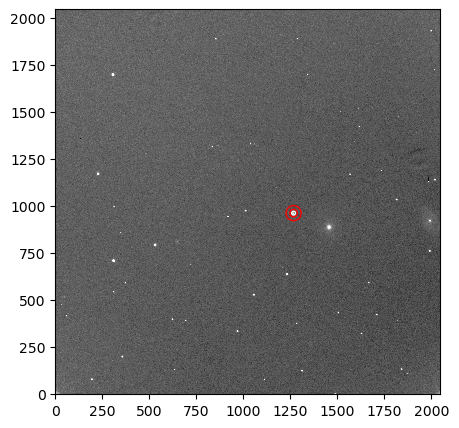

In [117]:
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
aperture = CircularAperture((x,y), r=10)
annulus_aperture = CircularAnnulus((x,y), r_in=20, r_out=40)
plt.figure(6,figsize=(5,5))
plt.imshow(cal,vmin=np.median(cal)-2*np.std(cal),vmax=np.median(cal)+5*np.std(cal))
aperture.plot(color='white', lw=1)
annulus_aperture.plot(color='red', lw=1)

Looks pretty good. It doesn't matter too much that the star does not appear perfectly in the center of the aperture. The aperture photometry routine will re-center on the star.

In [118]:
phot_table = aperture_photometry(cal, [aperture,annulus_aperture])
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1
,pix,pix,,
int64,float64,float64,float64,float64
1,1267.563753155879,963.2005816146343,380146.89417361317,4180499.476666812


"phot_table" is a astropy table with all the information one might want for simple aperture photometry. 

In [119]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_mean
bkg_sum = bkg_mean * aperture.area
bkg_sum
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,residual_aperture_sum
,pix,pix,,,
int64,float64,float64,float64,float64,float64
1,1267.563753155879,963.2005816146343,380146.89417361317,4180499.476666812,31771.93778471218


In [120]:
exptime = head['EXPTIME']
print('Total flux calculated in original image = %.2f counts per second' % (phot_table['residual_aperture_sum']/exptime))

Total flux calculated in original image = 264.77 counts per second


It can be seen from the plots that the counts plateau beyond about 10 pixels. We can take this aysmptotic value as the total counts of the supernova.

## Background subtraction
As you can see in the images above, the background was not perfectly uniform. In this case that is likely due to an imperfect flat. However sometimes it can be due to scattered light or to diffuse astronomical light, such as a galaxy or nebula. Sometimes it is advantageous to model and subtract background light before you do photometry. If done carefully, a background subtraction could take the place of the annulus aperture above. Below is a working example of how one might do this.

In [121]:
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()
#bkg_estimator = sigma_clip
bkg = Background2D(cal, box_size=(17, 17), filter_size=(31, 31), bkg_estimator=bkg_estimator)

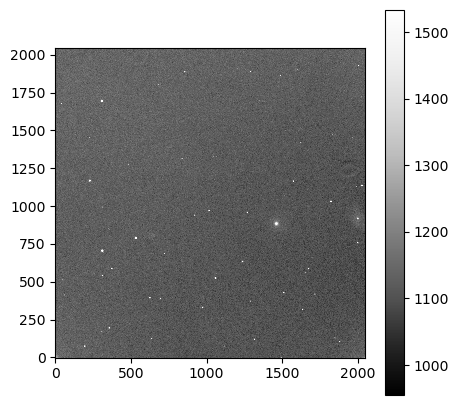

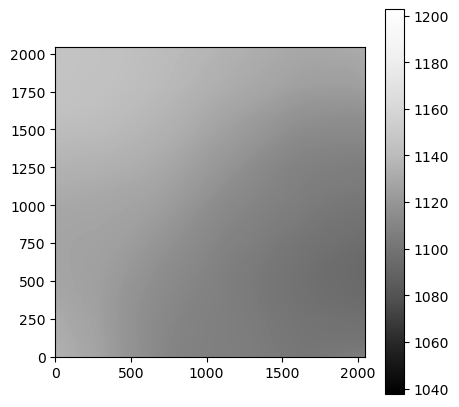

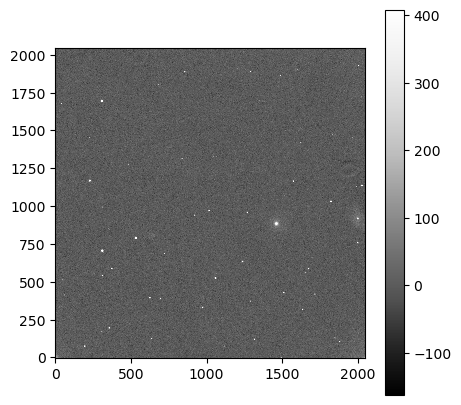

In [122]:
plt.figure(7,figsize=(5,5))
plt.imshow(cal,vmin=np.median(cal)-2*np.std(cal),vmax=np.median(cal)+5*np.std(cal))
plt.colorbar()
plt.figure(8,figsize=(5,5))
plt.imshow(bkg.background,vmin=np.median(cal)-1*np.std(cal),vmax=np.median(cal)+1*np.std(cal))
plt.colorbar()
plt.figure(9,figsize=(5,5))
cal_bkgsub = cal-bkg.background
plt.imshow(cal_bkgsub,vmin=np.median(cal_bkgsub)-2*np.std(cal_bkgsub),vmax=np.median(cal_bkgsub)+5*np.std(cal_bkgsub))
plt.colorbar()

It can be seen that the background subtracted image is much more "flat." We can apply the same aperture photometry parameters to this flattened image and compare our results.

In [123]:
phot_table2 = aperture_photometry(cal_bkgsub, aperture)
phot_table2

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,1267.563753155879,963.2005816146343,31412.52239673972


In [124]:
totflux_orig = phot_table['residual_aperture_sum'] / exptime
totflux_sub = phot_table2['aperture_sum'] / exptime
pdiff = np.abs(totflux_orig-totflux_sub)/np.mean([totflux_orig,totflux_sub]) * 100.0
print('Total flux calculated in original image = %.2f counts per second' % totflux_orig)
print('Total flux calculated in background subtracted image = %.2f counts per second' % totflux_sub)
print('Difference in photometry is %.4f percent' % pdiff)

Total flux calculated in original image = 264.77 counts per second
Total flux calculated in background subtracted image = 261.77 counts per second
Difference in photometry is 1.1377 percent


You can see that there is a measureable difference in the results, though it is a small difference.

# Exercise 1
Now that you know about simple aperture photometry, your task is to calculate the total flux in the supernova for each of the 5 images taken on the first night and then average them and estimate an error.
<ol>
<li>Reproduce the simple aperture photometry above in a few lines of code</li>
<li>Calibrate each image</li>
<li>Perform simple aperture photometry</li>
<li>Write a loop and accumulate the answers for each of the 5 images.</li>
<li>Average the values and take a standard deviation to estimate the error</li>
<li>Plot the results with errorbars---counts per second as a function of Julian Day. Julian Day can be accessed in the header of each file as header['JD']. Plot using the plt.errorbar function (very useful!)</li>
</ol>

In [125]:
def get_photometry(table, exptime, name: str):
    totflux = table['aperture_sum_1'] / exptime
    return totflux

bias,bh = fits.getdata('data/SN/20170713/master_bias.fits',header=True)
dark,dh = fits.getdata('data/SN/20170713/master_dark.fits',header=True)
flat,fh = fits.getdata('data/SN/20170713/master_flat_V.fits',header=True)

def eval_list(file_list, bias, dark, flat):
    count = 0
    for i in range(0,len(file_list)):
        im, head = fits.getdata(sfiles[i],header=True)
        cal = (im-bias-dark*head['EXPTIME'])/flat
        #Get the RA and DEC of the target 
        rastr  = head['RA']
        decstr = head['DEC']
        coords = SkyCoord(rastr,decstr,unit=(u.hour,u.deg))
        #Get the x and y pixel values of the target
        x,y = w.all_world2pix(coords.ra.deg, coords.dec.deg, 1)
        #Define the aperture and annulus
        aperture = CircularAperture((x,y), r=10)
        annulus_aperture = CircularAnnulus((x,y), r_in=20, r_out=40)
        #Get the table
        phot_table = aperture_photometry(cal, [aperture,annulus_aperture])
        #Get the background
        bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
        bkg_sum = bkg_mean * aperture.area
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['residual_aperture_sum'] = final_sum
        #Get the total flux
        exptime = head['EXPTIME']
        totflux_orig = phot_table['residual_aperture_sum'] / exptime
        count += totflux_orig
    return count/len(file_list)

avg = eval_list(sfiles, bias, dark, flat)
print(avg)

residual_aperture_sum
---------------------
    264.1645524164116


# Exercise 2
Run the second night of data (through the same procedure as in Exercise 1 and come to some conclusion about whether the supernova got brighter, dimmer, or remained the same brightness.

In [126]:
# These lines should get you started with the next set of data. 
bias2,bh2 = fits.getdata('data/SN/20170714/master_bias.fits',header=True)
dark2,dh2 = fits.getdata('data/SN/20170714/master_dark.fits',header=True)
flat2,fh2 = fits.getdata('data/SN/20170714/master_flat_V.fits',header=True)
sfiles2 = glob.glob('data/SN/20170714/SN*fits')
sct2 = len(sfiles2)
sfiles2

['data/SN/20170714/SN2017fgc-20170714at104443-Temp-30-Bin1-Exp120-V_solved.fits',
 'data/SN/20170714/SN2017fgc-20170714at103717-Temp-30-Bin1-Exp120-V_solved.fits',
 'data/SN/20170714/SN2017fgc-20170714at104708-Temp-30-Bin1-Exp120-V_solved.fits',
 'data/SN/20170714/SN2017fgc-20170714at104218-Temp-30-Bin1-Exp120-V_solved.fits',
 'data/SN/20170714/SN2017fgc-20170714at103953-Temp-30-Bin1-Exp120-V_solved.fits']

In [127]:
avg2 = eval_list(sfiles2, bias2, dark2, flat2)
print(avg2) 

print(1-(avg/avg2))


residual_aperture_sum
---------------------
     264.244727775453
residual_aperture_sum 
----------------------
0.00030341327797278606


The supernova is slightly brighter in the second set of data, but not by much.
If we knew the error on the measurements, we could do a t-test to see if the difference is significant.
Based on how little the supernova has changed (a small fraction of a percent), it is unlikely that the difference is significant.